# Import librairies

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split

import re # Import 're' module which provides functionality for manipulating regular expressions in Python.

from warnings import filterwarnings
filterwarnings('ignore')

c:\Users\33760\anaconda3\envs\myenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Discover Dataset

In [2]:
# Display the dataset and change the encoding of CSV
df_spam = pd.read_csv(r'C:\Users\33760\Desktop\FULLSTACK\FULLSTACK\Projet\BLOC 4\Spam detector\data\spam.csv', encoding='latin-1')
df_spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Create a Dataframe copy
df_copy = df_spam.copy()
df_copy.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Delete 'Unnamed' columns
df_spam = df_spam.drop(df_spam.columns[-3:], axis = 1)
df_spam.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Rename columns
df_spam.rename(columns={'v1': 'Category', 'v2': 'Message'}, inplace=True)
df_spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
print(f'This dataset contains {df_spam.shape[0]} raw and {df_spam.shape[1]} columns')

This dataset contains 5572 raw and 2 columns


In [7]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
# Check for missing values
df_spam.isnull().sum()

Category    0
Message     0
dtype: int64

We don't have missing values ​​in the dataset

In [9]:
# Check for duplicate rows
duplicates = df_spam.duplicated()

# Count the number of duplicate rows
num_duplicates = duplicates.sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 403


In [10]:
# Remove duplicate rows
df_unique = df_spam.drop_duplicates()

# Verify the new shape of the dataframe
print("Shape after removing duplicates:", df_unique.shape)

Shape after removing duplicates: (5169, 2)


Because of lack of information about the data collection process, the existence of duplicate rows may be attributed to potential errors that occurred during data collection. It is crucial to eliminate these duplicate entries as they can introduce biases into our algorithm and compromise the accuracy of our analysis.

In [11]:
df_spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Target distribution analysis

In [12]:
fig = px.histogram(
    df_spam, 
    x = df_spam['Category'], 
    color = df_spam.Category, 
    title = "Target distribution 'Category' (quantity)"
    )

fig.show()

In [13]:
fig = px.pie(
    df_spam, 
    names = df_spam['Category'], 
    color = df_spam.Category, 
    title = "Distribution of the target 'Category' in relative value"
    )

fig.show()

We can notice that the 'Category' target is very unbalanced with more than 86% of messages classified as non-spam

# Preprocessing

In [14]:
# import librairies
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33760\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
df_spam.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Calculate the number of characters in each message
df_spam["caracter_nb"] = df_spam["Message"].apply(len)

# Tokenize each message into words and calculate the number of words
df_spam["word_nb"] = df_spam.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1).apply(len)

# Tokenize each message into sentences and calculate the number of sentences
df_spam["sentence_nb"] = df_spam.apply(lambda row: nltk.sent_tokenize(row["Message"]), axis=1).apply(len)

In [17]:
df_spam.head()

,Category,Message,caracter_nb,word_nb,sentence_nb
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [18]:
# Display distribution and range
df_spam.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
caracter_nb,5572.000000,80.118808,59.690841,2.000000,36.000000,61.000000,121.000000,910.000000
word_nb,5572.000000,18.695621,13.742587,1.000000,9.000000,15.000000,27.000000,220.000000
sentence_nb,5572.000000,1.970747,1.417778,1.000000,1.000000,1.000000,2.000000,28.000000


The generated table will display summary statistics for each column in the DataFrame. The color gradient applied to the table visually represents the magnitude of the values. This allows for a rapid visual comprehension of the distribution and range of the variables within the DataFrame.

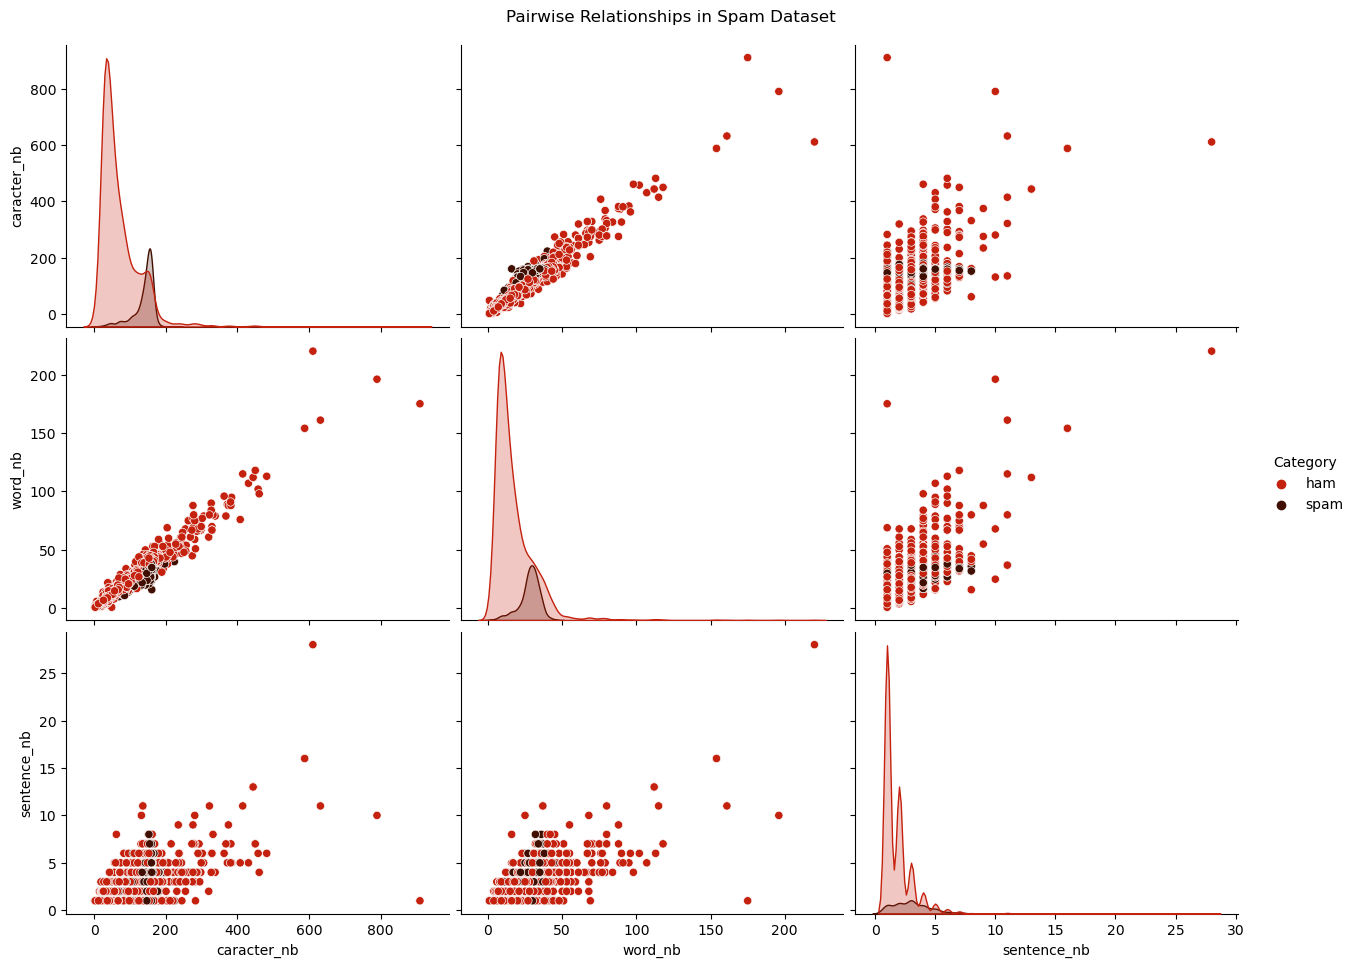

In [19]:
fig = sns.pairplot(data=df_spam, hue="Category", palette=["#C4210E", "#410F01"], height=3.15, aspect=1.35)
fig.fig.suptitle("Pairwise Relationships in Spam Dataset", y=1.02)
plt.show(fig);

# Natural Langage Processing

In [20]:
df_spam.head()

,Category,Message,caracter_nb,word_nb,sentence_nb
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [21]:
# Convert category in two classes (0 = ham / 1 = Spam)
df_spam['Category'] = df_spam['Category'].apply(lambda x: 0 if x == 'ham' else 1)
df_spam.head()

,Category,Message,caracter_nb,word_nb,sentence_nb
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [22]:
# Delete caracter_nb, word_nb and sentence_nb columns
df_spam = df_spam.drop(df_spam.columns[2:], axis=1)
df_spam.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
# Create a column that iterates over each document in the message corpus to replace all characters that are not letters, numbers, or spaces with a space (regex) .
df_spam['clean_message'] = df_spam['Message'].str.replace(r"[^A-Za-z0-9 ]+", " ") 

# Convert uppercase letters to lowercase
df_spam['clean_message'] = df_spam['clean_message'].apply(lambda x: x.lower())

In [24]:
df_spam.head(15)

,Category,Message,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...
5,1,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it s been 3 week s n...
6,0,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me ...
7,0,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnamin...
8,1,WINNER!! As a valued network customer you have...,winner as a valued network customer you have ...
9,1,Had your mobile 11 months or more? U R entitle...,had your mobile 11 months or more u r entitle...


In [25]:
# Deletion of all individual digits and sequences of digits
df_spam['clean_message'] = df_spam['clean_message'].apply(lambda x: re.sub(r'\d+', '', x))

In [26]:
df_spam.head(15)

,Category,Message,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only i...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...
5,1,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it s been week s no...
6,0,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me ...
7,0,As per your request 'Melle Melle (Oru Minnamin...,as per your request melle melle oru minnamin...
8,1,WINNER!! As a valued network customer you have...,winner as a valued network customer you have ...
9,1,Had your mobile 11 months or more? U R entitle...,had your mobile months or more u r entitled ...


Now the text is preprocessed, we will proceed to tokenization, which is the process of isolating each word in each document as a token, this will be a good opportunity to remove stop words tokens.

In [27]:
# Import english
import en_core_web_sm
nlp = en_core_web_sm.load()

# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [28]:
# Print stop words
print(STOP_WORDS)

{'always', 'each', 'thence', 'those', 'might', 'amongst', 'nevertheless', 'yet', 'whoever', 'should', 'of', 'there', 'was', 'toward', 'sixty', 'from', 'everyone', 'someone', 'whence', 'put', "'s", 'formerly', 'latterly', 'yourselves', 'using', 'mostly', 'say', 'just', 'cannot', 'seem', 'call', 'when', 'no', 'one', 'too', 'hers', '’s', 'never', 'am', 'almost', 'could', '’ll', 'same', 'himself', 'twelve', 'can', 'being', 'empty', 'will', 'some', 'wherein', 'whatever', 'front', 'does', 'five', 'keep', 'who', 'make', 'anyhow', 'rather', 'whereafter', 'more', 'least', 'sometimes', 'herself', 'fifty', 'she', 'why', 'me', 'upon', 'is', 'once', 'he', 'the', 'meanwhile', 'into', 'ourselves', 'somehow', 'we', 'another', 'several', 'with', 'did', 'very', 'throughout', 'nine', 'even', 'in', 'these', 'whom', 'became', 'anywhere', 'only', '‘re', 'nobody', 'how', 'beside', 'then', 'below', 'enough', 'two', 'seemed', 'and', 'by', 'seems', '’d', 'beyond', 'already', 'your', 'while', 'third', 'yours', '

In [29]:
# Tokenization
tokenized_clean_message = df_spam['clean_message'].apply(lambda x: nlp(x))
tokenized_clean_message

0       (go, until, jurong, point,  , crazy,  , availa...
1                       (ok, lar,  , joking, wif, u, oni)
2       (free, entry, in,  , a, wkly, comp, to, win, f...
3       (u, dun, say, so, early, hor,  , u, c, already...
4       (nah, i, don, t, think, he, goes, to, usf,  , ...
                              ...                        
5567    (this, is, the, nd, time, we, have, tried,  , ...
5568        (will,   , b, going, to, esplanade, fr, home)
5569    (pity,    , was, in, mood, for, that,  , so, a...
5570    (the, guy, did, some, bitching, but, i, acted,...
5571                  (rofl,  , its, true, to, its, name)
Name: clean_message, Length: 5572, dtype: object

In [30]:
# Remove stop-words and Lemmatization
tokenized_clean_message = tokenized_clean_message.apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
tokenized_clean_message

0       [jurong, point,  , crazy,  , available, bugis,...
1                         [ok, lar,  , joke, wif, u, oni]
2       [free, entry,  , wkly, comp, win, fa, cup, fin...
3                           [u, dun, early, hor,  , u, c]
4                  [nah, don, t, think, go, usf,  , live]
                              ...                        
5567    [nd, time, try,  , contact, u,  , u, win,   , ...
5568                     [  , b, go, esplanade, fr, home]
5569                     [pity,    , mood,  , suggestion]
5570    [guy, bitching, act, like, d, interested, buy,...
5571                                      [rofl,  , true]
Name: clean_message, Length: 5572, dtype: object

In [31]:
# Add a clean token column (detokenized)
df_spam["clean_token"] = [" ".join(x) for x in tokenized_clean_message]
df_spam.tail(15)

,Category,Message,clean_message,clean_token
5557,0,No. I meant the calculation is the same. That ...,no i meant the calculation is the same that ...,mean calculation lt gt unit lt gt ...
5558,0,"Sorry, I'll call later",sorry i ll call later,sorry ll later
5559,0,if you aren't here in the next &lt;#&gt; hou...,if you aren t here in the next lt gt hours...,aren t lt gt hour imma flip shit
5560,0,Anything lor. Juz both of us lor.,anything lor juz both of us lor,lor juz lor
5561,0,Get me out of this dump heap. My mom decided t...,get me out of this dump heap my mom decided t...,dump heap mom decide come lowes boring
5562,0,Ok lor... Sony ericsson salesman... I ask shuh...,ok lor sony ericsson salesman i ask shuhui t...,ok lor sony ericsson salesman ask shuhui g...
5563,0,Ard 6 like dat lor.,ard like dat lor,ard like dat lor
5564,0,Why don't you wait 'til at least wednesday to ...,why don t you wait til at least wednesday to ...,don t wait til wednesday
5565,0,Huh y lei...,huh y lei,huh y lei
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,reminder from o to get pounds free call cre...,reminder o pound free credit detail great...


In [32]:
# Remove URLs from texts if there is any
df_spam["clean_token"] = df_spam["clean_token"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

We can notice than some messages are written in SMS language. WHICH means that the words are not referenced in the stop words dictionnary (example: you = u, to = 2, second = 2nd...). We need to handle this problem

In [33]:
# Delete words that have less than 2 letters or less
df_spam['clean_token'] = df_spam['clean_token'].apply(lambda x: ' '.join(word for word in x.split() if len(word) >= 3))

In [34]:
# Check than all the documentss in 'clean_token' are str
mask = df_spam.clean_token.apply(lambda x: type(x)==str)
mask.value_counts()

True    5572
Name: clean_token, dtype: int64

In [35]:
# Import Tensorfow librairies
import tensorflow as tf
import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

Do a `train_test_split` of your data (keep about 70% in the train). For this you may use `sklearn.model_selection.train_test_split`.

In [36]:
# Import train_tes_split
from sklearn.model_selection import train_test_split

# Séparation en train et test
train_df_spam, test_df_spam = train_test_split(df_spam, test_size=0.3, random_state=112)

# Affichage des tailles des ensembles
print("Training set size :", len(train_df_spam))
print("Tets set size :", len(test_df_spam))

Training set size : 3900
Tets set size : 1672


In [37]:
train_df_spam.head()

,Category,Message,clean_message,clean_token
593,0,You still at grand prix?,you still at grand prix,grand prix
3623,0,No message..no responce..what happend?,no message no responce what happend,message responce happend
5144,0,I'm in office now da:)where are you?,i m in office now da where are you,office
262,0,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,my no in luton ring me if ur around h,luton ring
1625,0,Hi Dear Call me its urgnt. I don't know whats ...,hi dear call me its urgnt i don t know whats ...,dear urgnt don know problem don want work prob...


In [38]:
test_df_spam.head()

,Category,Message,clean_message,clean_token
4771,0,"Hi, Mobile no. &lt;#&gt; has added you in th...",hi mobile no lt gt has added you in thei...,mobile add contact list www fullonsm com great...
1278,0,Can i meet Ì_ at 5.. As 4 where depends on whe...,can i meet at as where depends on where ...,meet depend wan lor
1288,0,Happy new year to u too!,happy new year to u too,happy new year
3416,0,But i haf enuff space got like 4 mb...,but i haf enuff space got like mb,haf enuff space get like
4704,0,Hey anyway i have to :-),hey anyway i have to,hey


Using `tf.keras.preprocessing.text.Tokenizer`  process to encoding all the reviews 

In [39]:
# Instance of the Tokenizer class from the Keras preprocessing library to keep 1000 most frequent words
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")# None ou "<UNK>"

# Build the vocabulary based on the frequency of words
# fit the tokenizer on the texts in this step the tokenizer will list all unique tokens in the text
# and associate them with a specific integer.
tokenizer.fit_on_texts(train_df_spam.clean_token)

# This step will effectively transform the texts into sequences of indices
train_df_spam["message_encoded"] = tokenizer.texts_to_sequences(train_df_spam.clean_token)

In [40]:
# Sometimes the preprocessing removes all the words in a string (because they contain
# only stopwords for example) so we calculate the length in order to filter out
# those records
train_df_spam["len_message"] = train_df_spam["message_encoded"].apply(lambda x: len(x))
train_df_spam = train_df_spam[train_df_spam["len_message"] != 0]

In [41]:
# We do the same on the test set, except we do not fit the tokenizer this time
test_df_spam["message_encoded"] = tokenizer.texts_to_sequences(test_df_spam.clean_token)
test_df_spam["len_message"] = test_df_spam["message_encoded"].apply(lambda x: len(x))
test_df_spam = test_df_spam[test_df_spam["len_message"]!=0]

In [42]:
train_df_spam.head()

,Category,Message,clean_message,clean_token,message_encoded,len_message
593,0,You still at grand prix?,you still at grand prix,grand prix,"[1, 1]",2
3623,0,No message..no responce..what happend?,no message no responce what happend,message responce happend,"[35, 1, 1]",3
5144,0,I'm in office now da:)where are you?,i m in office now da where are you,office,[239],1
262,0,MY NO. IN LUTON 0125698789 RING ME IF UR AROUN...,my no in luton ring me if ur around h,luton ring,"[1, 346]",2
1625,0,Hi Dear Call me its urgnt. I don't know whats ...,hi dear call me its urgnt i don t know whats ...,dear urgnt don know problem don want work prob...,"[40, 1, 22, 4, 128, 22, 10, 30, 128, 15, 1, 19]",12


In [43]:
test_df_spam.head()

,Category,Message,clean_message,clean_token,message_encoded,len_message
4771,0,"Hi, Mobile no. &lt;#&gt; has added you in th...",hi mobile no lt gt has added you in thei...,mobile add contact list www fullonsm com great...,"[27, 563, 77, 817, 69, 1, 95, 51, 93, 6, 9, 11...",15
1278,0,Can i meet Ì_ at 5.. As 4 where depends on whe...,can i meet at as where depends on where ...,meet depend wan lor,"[49, 1, 103, 25]",4
1288,0,Happy new year to u too!,happy new year to u too,happy new year,"[45, 38, 82]",3
3416,0,But i haf enuff space got like 4 mb...,but i haf enuff space got like mb,haf enuff space get like,"[358, 1, 949, 5, 12]",5
4704,0,Hey anyway i have to :-),hey anyway i have to,hey,[48],1


In [44]:
# Display the lookup table for the words and indices
tokenizer.index_word

{1: 'out_of_vocab',
 2: 'not',
 3: 'come',
 4: 'know',
 5: 'get',
 6: 'send',
 7: 'good',
 8: 'day',
 9: 'free',
 10: 'want',
 11: 'time',
 12: 'like',
 13: 'love',
 14: 'text',
 15: 'tell',
 16: 'think',
 17: 'today',
 18: 'need',
 19: 'reply',
 20: 'win',
 21: 'stop',
 22: 'don',
 23: 'sorry',
 24: 'txt',
 25: 'lor',
 26: 'home',
 27: 'mobile',
 28: 'week',
 29: 'say',
 30: 'work',
 31: 'later',
 32: 'ask',
 33: 'night',
 34: 'phone',
 35: 'message',
 36: 'pls',
 37: 'leave',
 38: 'new',
 39: 'miss',
 40: 'dear',
 41: 'min',
 42: 'hope',
 43: 'thing',
 44: 'number',
 45: 'happy',
 46: 'try',
 47: 'wait',
 48: 'hey',
 49: 'meet',
 50: 'wat',
 51: 'great',
 52: 'friend',
 53: 'feel',
 54: 'claim',
 55: 'yeah',
 56: 'thank',
 57: 'late',
 58: 'let',
 59: 'way',
 60: 'msg',
 61: 'tomorrow',
 62: 'find',
 63: 'prize',
 64: 'babe',
 65: 'yes',
 66: 'cash',
 67: 'right',
 68: 'call',
 69: 'www',
 70: 'service',
 71: 'pick',
 72: 'tone',
 73: 'life',
 74: 'sleep',
 75: 'amp',
 76: 'sure',
 7

We are almost done now, the texts have been converted into sequences of integers. However to form a tensorflow dataset, all the sequences must be of the same length, so we'll use padding. Padding will result in adding zeros at the end or the beginning of each sentence in order for all sequences to be of the same length.

For this we will use the `tf.keras.preprocessing.sequence.pad_sequences`

In [45]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_df_spam.message_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_df_spam.message_encoded, padding="post")

Now we can properly form tensorflow datasets using `tf.data.Dataset.from_tensor_slices`. 

In [46]:
# We'll use this to form a tensorflow dataset

# creates two sets of data, train_ds and val_ds, from encoded texts and labels
train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train_df_spam.Category))
val_ds = tf.data.Dataset.from_tensor_slices((test_pad, test_df_spam.Category))

# We then organize the dataste per batch
train_ds = train_ds.shuffle(len(train_ds)).batch(1024)
val_ds = val_ds.shuffle(len(val_ds)).batch(1024)

In [47]:
# Look at a batch of data 
for message, label in train_ds.take(1):
  print(message, label)

tf.Tensor(
[[  1   1   1 ...   0   0   0]
 [505   5   1 ...   0   0   0]
 [ 78  27   1 ...   0   0   0]
 ...
 [358   1  25 ...   0   0   0]
 [  2 180  93 ...   0   0   0]
 [ 78  27  44 ...   0   0   0]], shape=(1024, 55), dtype=int32) tf.Tensor([1 0 1 ... 0 1 1], shape=(1024,), dtype=int64)


### Define the model
Now that the text has been properly encoded, we can proceed to building the model for classifying the texts. Our goal is to train the embedding layer, so we will keep the model simple.

It's important to note that the purpose of embedding is to map the vocabulary space to a lower-dimensional representation space. As a result, some words will have similar vectors in the representation space, while others will have more distinct vectors. However, the similarity or dissimilarity of words in this embedding space is not determined by a general understanding of the language. Instead, the mapping is learned through a supervised learning task.

In [79]:
embedding_dim = 16 # the dimensionality of the representation space

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = tf.keras.Sequential([
    # Couche d'Input Word Embedding
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, name="embedding"), # the embedding layer
    # the input needs to be equal to the size of the vocabulary + 1 (because of the zero padding)
    
    # Gobal average pooling (pick average for every word in the sentence)
    tf.keras.layers.GlobalAveragePooling1D(),

    # Couche Dense classique
    tf.keras.layers.Dense(16, activation='relu'),

    # Couche de sortie avec le nombre de neurones en sortie égal au nombre de classe avec une fonction Sigmoïd
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [80]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16016     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,305
Trainable params: 16,305
Non-trainable params: 0
_________________________________________________________________


In [81]:
#Compile the model with the correct loss function and the Adam optimizer
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
                      

In [82]:
# Fit the model on 20 epochs
history = model.fit(train_ds, 
                    epochs=165, 
                    validation_data=val_ds)

Epoch 1/165


4/4 [==============================] - 2s 109ms/step - loss: 0.6990 - accuracy: 0.1396 - val_loss: 0.6929 - val_accuracy: 0.5441
Epoch 2/165
4/4 [==============================] - 0s 24ms/step - loss: 0.6904 - accuracy: 0.7704 - val_loss: 0.6875 - val_accuracy: 0.8635
Epoch 3/165
4/4 [==============================] - 0s 23ms/step - loss: 0.6863 - accuracy: 0.8649 - val_loss: 0.6841 - val_accuracy: 0.8635
Epoch 4/165
4/4 [==============================] - 0s 27ms/step - loss: 0.6827 - accuracy: 0.8649 - val_loss: 0.6801 - val_accuracy: 0.8635
Epoch 5/165
4/4 [==============================] - 0s 25ms/step - loss: 0.6781 - accuracy: 0.8649 - val_loss: 0.6744 - val_accuracy: 0.8635
Epoch 6/165
4/4 [==============================] - 0s 23ms/step - loss: 0.6720 - accuracy: 0.8649 - val_loss: 0.6677 - val_accuracy: 0.8635
Epoch 7/165
4/4 [==============================] - 0s 27ms/step - loss: 0.6649 - accuracy: 0.8649 - val_loss: 0.6603 - val_accuracy: 0.8635
Epoch 8/165
4/4 [==============

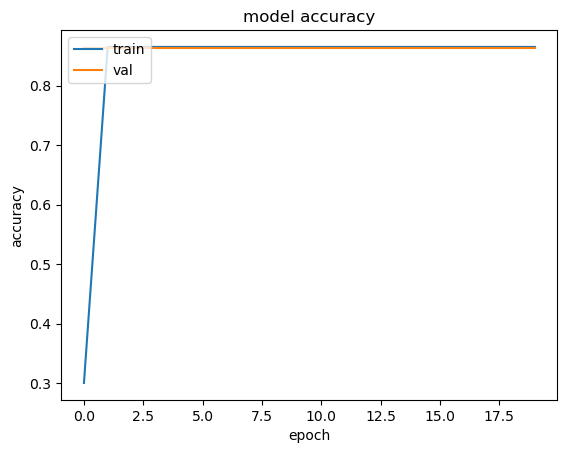

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

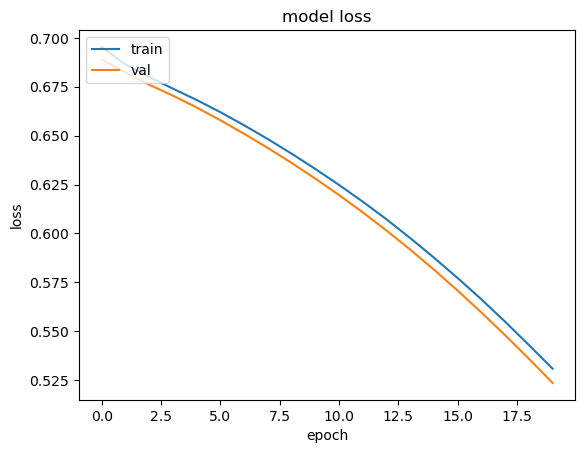

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
vocab = [value for value in tokenizer.index_word.values()]
vocab = vocab[:10000]
weights = model.get_layer('embedding').get_weights()[0]

In [55]:
weights.shape

(1001, 16)

In [56]:
# Consult weight of word in the vocabulary in fonction of index
weights[8] # weight of word 'free'

array([ 0.06887829, -0.02118617,  0.04341702, -0.02152271,  0.066427  ,
       -0.04626136, -0.09470482, -0.03419624, -0.0454502 ,  0.035719  ,
        0.03456522, -0.08437414,  0.11030709,  0.12027578, -0.0615375 ,
        0.06885625], dtype=float32)

(loss): The loss describes the average error of the model during training. As the epochs progress, the loss steadily decreases. This indicates that our model is gradually learning to better predict email labels.

(accuracy): Accuracy measures the proportion of samples correctly classified by the model. It also steadily increases from 0.9712 to 0.9795 on the training set. This shows that your model is getting more and more accurate as it trains.

(val_loss) and (val_accuracy): These metrics represent the performance of our model on a separate validation dataset, which was not used for training. The values of val_loss and val_accuracy follow a similar pattern to training loss and accuracy, indicating that our model generalizes well and does not overfit the training data.

Overall, our results show that the spam or non-spam e-mail classification model gradually improves over time. The loss and accuracy metrics indicate good model convergence, while the validation metrics suggest good generalization to unknown data.

In the context of a classification with an unbalanced label, it is generally advisable to consider several metrics to evaluate the performance of the model, the loss and the accuracy are not sufficient. The precision, the recall and the F1 score are particularly indicated in this kind of problem.
We are going to concentrate on the validation data because they refer us to the use of the model in a real situation.

In [62]:
#Compile the model with the correct loss function ,the Adam optimizer and metrics
optimizer_2= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer_2,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TruePositives()])

In [65]:
# Fit the model on 165 epochs
history = model.fit(train_ds, 
                    epochs=165, 
                    validation_data=val_ds)

Epoch 1/165
4/4 [==============================] - 0s 26ms/step - loss: 0.1986 - false_negatives_1: 331.0000 - true_negatives_1: 3333.0000 - false_positives_1: 1.0000 - true_positives_1: 190.0000 - val_loss: 0.2054 - val_false_negatives_1: 146.0000 - val_true_negatives_1: 1430.0000 - val_false_positives_1: 0.0000e+00 - val_true_positives_1: 80.0000
Epoch 2/165
4/4 [==============================] - 1s 191ms/step - loss: 0.1946 - false_negatives_1: 321.0000 - true_negatives_1: 3333.0000 - false_positives_1: 1.0000 - true_positives_1: 200.0000 - val_loss: 0.2016 - val_false_negatives_1: 142.0000 - val_true_negatives_1: 1430.0000 - val_false_positives_1: 0.0000e+00 - val_true_positives_1: 84.0000
Epoch 3/165
4/4 [==============================] - 0s 28ms/step - loss: 0.1908 - false_negatives_1: 313.0000 - true_negatives_1: 3333.0000 - false_positives_1: 1.0000 - true_positives_1: 208.0000 - val_loss: 0.1978 - val_false_negatives_1: 138.0000 - val_true_negatives_1: 1430.0000 - val_false_po

In [66]:
# Metrics extraction validation set
# Retrieve metric values 
fn = model.metrics[-4].result().numpy()  # False Negatives
tn = model.metrics[-3].result().numpy()  # True Negatives
fp = model.metrics[-2].result().numpy()  # False Positives
tp = model.metrics[-1].result().numpy()  # True Positives

# Create a dataframe to analyze the values
data = {'Metric': ['False Negatives', 'True Negatives', 'False Positives', 'True Positives'],
        'Value': [fn, tn, fp, tp]}

df_metrics = pd.DataFrame(data)
df_metrics

,Metric,Value
0,False Negatives,28.0
1,True Negatives,1423.0
2,False Positives,7.0
3,True Positives,198.0


In [67]:
# Calculates percentage of metrics (TP, TN, FP, FN)
false_neg_p = round((df_metrics.Value[0] / (df_metrics.Value[0] + df_metrics.Value[1])) *100,2)
true_neg_p = 100-false_neg_p
false_pos_p = round((df_metrics.Value[2] / (df_metrics.Value[2] + df_metrics.Value[3])) *100,2)
true_pos_p = 100-false_pos_p

In [68]:
# Add the metrics to the dataframe
df_metrics = df_metrics.assign(Percentage=[false_neg_p, true_neg_p, false_pos_p, true_pos_p])

In [69]:
df_metrics

,Metric,Value,Percentage
0,False Negatives,28.0,1.93
1,True Negatives,1423.0,98.07
2,False Positives,7.0,3.41
3,True Positives,198.0,96.59


False-positive

In a spam / non-spam classification problem what we want to avoid above all is that non-spam emails are classified by our model as spam. Our model is effective for this task since we can see that out of the 200 spam validation data only 7 were misclassified, or 3.5%.

False N

False-negative
Another important result, of course, is that our spam detector is good on it. Of the 1456 Spams in our validation set, only 28 escaped the detector, giving a success rate of 98.07%.

In [70]:
# Extract the values from the DataFrame
true_negatives = df_metrics.loc[1, 'Value']
false_negatives = df_metrics.loc[0, 'Value']
false_positives = df_metrics.loc[2, 'Value']
true_positives = df_metrics.loc[3, 'Value']

# Calculate Precision, Recall, and F1-Score
recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a DataFrame
df_metrics_2 = pd.DataFrame({'Metric': ['Recall', 'Precision', 'F1-Score'],
                           'Value': [recall, precision, f1_score]})

df_metrics_2

,Metric,Value
0,Recall,0.876106
1,Precision,0.965854
2,F1-Score,0.918793


Concerning the performance rating, our model got a recall of 87 %, which means it managed to capture the majority of spam emails. The 96.5% precision indicates that most emails identified as spam were indeed spam. The F1 score of 0.92 indicates a good balance between precision and recall.

However, there is still possibility to reduce false negatives (spam classified as non-spam) and false positives (non-spam classified as spam). It would be important to verify the performance of your model on an independent test set to get a more complete assessment of its ability to generalize and make accurate decisions in real-world situations.

In summary, the model shows promising potential in classifying spam or non-spam emails, but further refinements may be needed to achieve even better performance.